In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
train_dir = '/kaggle/input/wet-wipe/train'
test_dir = '/kaggle/input/wet-wipe/test'
valid_dir = '/kaggle/input/wet-wipe/valid'

train_images_dir = os.path.join(train_dir, 'images')
test_images_dir = os.path.join(test_dir, 'images')
valid_images_dir = os.path.join(valid_dir, 'images')

train_labels_dir = os.path.join(train_dir, 'labels')
test_labels_dir = os.path.join(test_dir, 'labels')
valid_labels_dir = os.path.join(valid_dir, 'labels')

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 224  # Resize all images to 224x224 for CNN

def load_and_preprocess_data(image_dir, label_dir):
    images = []
    labels = []

    for filename in os.listdir(image_dir):
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, filename.replace('.jpg', '.txt'))

        if not os.path.exists(label_path):
            continue

        # Load image
        image = cv2.imread(image_path)
        height, width = image.shape[:2]

        with open(label_path, 'r') as file:
            for line in file.readlines():
                class_id, x_center, y_center, w, h = map(float, line.strip().split())

                x_center *= width
                y_center *= height
                w *= width
                h *= height

                x1 = int(x_center - w / 2)
                y1 = int(y_center - h / 2)
                x2 = int(x_center + w / 2)
                y2 = int(y_center + h / 2)

                cropped_object = image[y1:y2, x1:x2]

                if cropped_object.size == 0:
                    continue  # Skip if the crop is invalid

                # Resize image for CNN
                cropped_object = cv2.resize(cropped_object, (IMG_SIZE, IMG_SIZE))
                cropped_object = cropped_object / 255.0  # Normalize

                images.append(cropped_object)
                labels.append(int(class_id))

    return np.array(images), np.array(labels)

# Load Training Data
X_train, y_train = load_and_preprocess_data(train_images_dir, train_labels_dir)
X_test, y_test = load_and_preprocess_data(test_images_dir, test_labels_dir)

# Convert labels to one-hot encoding
num_classes = len(set(y_train))  # Number of unique classes
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(f"Train Data Shape: {X_train.shape}, Train Labels Shape: {y_train.shape}")
print(f"Test Data Shape: {X_test.shape}, Test Labels Shape: {y_test.shape}")


Train Data Shape: (287, 224, 224, 3), Train Labels Shape: (287, 2)
Test Data Shape: (14, 224, 224, 3), Test Labels Shape: (14, 2)


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories
train_dir = "/kaggle/input/wet-wipe/train"
test_dir = "/kaggle/input/wet-wipe/test"
valid_dir = "/kaggle/input/wet-wipe/valid"

train_images_dir = os.path.join(train_dir, "images")
test_images_dir = os.path.join(test_dir, "images")
valid_images_dir = os.path.join(valid_dir, "images")

train_labels_dir = os.path.join(train_dir, "labels")
test_labels_dir = os.path.join(test_dir, "labels")
valid_labels_dir = os.path.join(valid_dir, "labels")

IMG_SIZE = 224  # Resize all images for CNN input

# Function to extract bounding boxes from YOLO label files
def get_cropped_images_and_labels(image_dir, label_dir):
    data = []
    
    for filename in os.listdir(image_dir):
        if not filename.endswith(".jpg"):
            continue
        
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, filename.replace(".jpg", ".txt"))

        if not os.path.exists(label_path):
            continue

        image = cv2.imread(image_path)
        height, width = image.shape[:2]

        with open(label_path, "r") as file:
            for line in file.readlines():
                class_id, x_center, y_center, w, h = map(float, line.strip().split())

                # Convert YOLO format to pixel coordinates
                x_center *= width
                y_center *= height
                w *= width
                h *= height

                x1 = int(x_center - w / 2)
                y1 = int(y_center - h / 2)
                x2 = int(x_center + w / 2)
                y2 = int(y_center + h / 2)

                # Crop the image
                cropped_object = image[max(0, y1):min(height, y2), max(0, x1):min(width, x2)]
                
                if cropped_object.size == 0:
                    continue  # Skip invalid crops

                # Save cropped image temporarily for ImageDataGenerator
                cropped_path = f"/kaggle/working/cropped/{filename}"
                cv2.imwrite(cropped_path, cv2.resize(cropped_object, (IMG_SIZE, IMG_SIZE)))

                # Append binary labels (assuming two classes: 0 and 1)
                data.append([cropped_path, int(class_id)])

    return pd.DataFrame(data, columns=["filepath", "class"])

# Generate cropped datasets
os.makedirs("/kaggle/working/cropped", exist_ok=True)

train_df = get_cropped_images_and_labels(train_images_dir, train_labels_dir)
test_df = get_cropped_images_and_labels(test_images_dir, test_labels_dir)
valid_df = get_cropped_images_and_labels(valid_images_dir, valid_labels_dir)

# Convert labels to binary (0 or 1)
train_df["class"] = train_df["class"].apply(lambda x: 1 if x == 1 else 0)
valid_df["class"] = valid_df["class"].apply(lambda x: 1 if x == 1 else 0)
test_df["class"] = test_df["class"].apply(lambda x: 1 if x == 1 else 0)

train_df["class"] = train_df["class"].astype(str)
valid_df["class"] = valid_df["class"].astype(str)
test_df["class"] = test_df["class"].astype(str)


# ImageDataGenerator with Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create Generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode="binary"
)

valid_generator = test_datagen.flow_from_dataframe(
    valid_df,
    x_col="filepath",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode="binary"
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="class",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

# Print dataset info
print(f"Train samples: {len(train_df)}, Valid samples: {len(valid_df)}, Test samples: {len(test_df)}")


Found 287 validated image filenames belonging to 2 classes.
Found 27 validated image filenames belonging to 2 classes.
Found 14 validated image filenames belonging to 2 classes.
Train samples: 287, Valid samples: 27, Test samples: 14


# **Building the CNN model**

In [4]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=4,activation='relu',input_shape=(224,224,3)))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))        
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=4,activation='relu'))        
cnn.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
cnn.add(tf.keras.layers.Flatten())        
cnn.add(tf.keras.layers.Dense(units = 128,activation='relu'))        
cnn.add(tf.keras.layers.Dropout(0.5))        
cnn.add(tf.keras.layers.Dense(units = 1,activation='sigmoid'))        
        

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
cnn.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'])

In [6]:

cnn.fit(x=train_generator,epochs=25,validation_data =test_generator )

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6565 - loss: 1.0986 - val_accuracy: 0.9286 - val_loss: 0.4231
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8423 - loss: 0.5043 - val_accuracy: 0.9286 - val_loss: 0.2875
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8408 - loss: 0.4976 - val_accuracy: 0.9286 - val_loss: 0.3205
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8488 - loss: 0.4530 - val_accuracy: 0.9286 - val_loss: 0.2878
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8544 - loss: 0.4207 - val_accuracy: 0.9286 - val_loss: 0.2655
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8832 - loss: 0.3712 - val_accuracy: 0.9286 - val_loss: 0.2528
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8923 - loss: 0.3580 - val_accuracy: 0.9286 - val_loss: 0.2653
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.8989 - loss: 0.3819 - val_accuracy: 0.9286 - val_loss: 0.4196
Epoch 9/25
9/9 ━━━━

In [7]:
test_loss, test_accuracy = cnn.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9286 - loss: 0.4601
Test Loss: 0.46011775732040405
Test Accuracy: 0.9285714030265808


In [9]:
# Generate predictions on the test data
predictions = cnn.predict(test_generator)

# Convert probabilities to binary labels (assuming a 0.5 threshold)
predicted_classes = (predictions > 0.5).astype("int32").reshape(-1)

# Get true labels from the generator (ensure shuffle=False when creating test_generator)
true_classes = test_generator.classes

# Optional: Print detailed classification metrics
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
Confusion Matrix:
[[ 0  1]
 [ 0 13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.93      1.00      0.96        13

    accuracy                           0.93        14
   macro avg       0.46      0.50      0.48        14
weighted avg       0.86      0.93      0.89        14



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


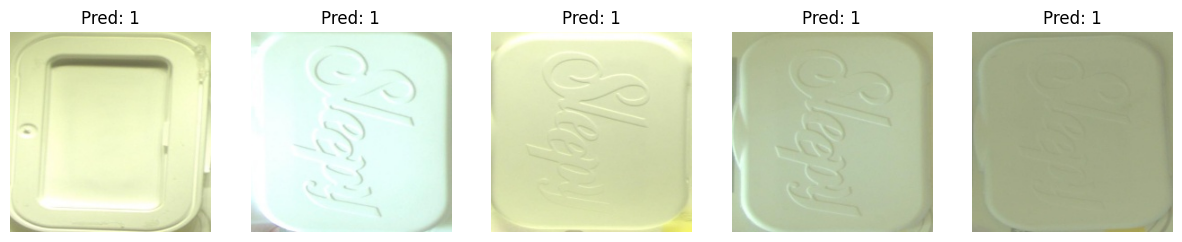

In [10]:
import matplotlib.pyplot as plt

images, labels = next(test_generator)
preds = cnn.predict(images)
pred_classes = (preds > 0.5).astype("int32")

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"Pred: {pred_classes[i][0]}")
    plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


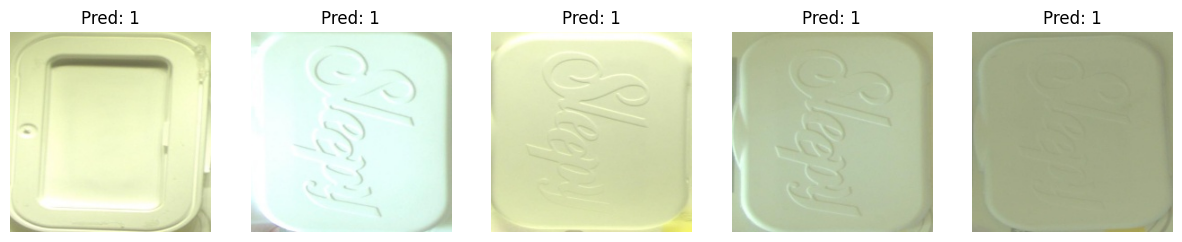

In [11]:
images, labels = next(test_generator)
preds = cnn.predict(images)
pred_classes = (preds > 0.5).astype("int32")

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"Pred: {pred_classes[i][0]}")
    plt.axis("off")
plt.show()
